In [1]:
from collections import defaultdict
import glob
from os.path import join
import os
import random
import string
import tarfile
import zipfile

In [2]:
import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np
from scipy.io import loadmat

In [3]:
from mxnet import gluon, nd, autograd

### Get Data

In [356]:
import PIL
from PIL import Image, ImageDraw, ImageFont, ImageOps

In [354]:
%%time
W, H = (300,200)
im = Image.new("RGBA",(W,H),"white")
msg = "al"
for i, char in enumerate(msg):    
    size = random.gauss(200, 10)
    im_char = Image.new("RGBA",(W,H), (255, 0, 0, 0))
    draw = ImageDraw.Draw(im_char)
    rotate = random.gauss(0, 5)
    font = ImageFont.truetype('dataset/fonts/Linoleo Script.ttf', size=int(size))    
    slide = random.gauss(0.6, 0.3)
    w, h = draw.textsize(char, font)
    draw.text(((W-w)/2-w + slide*i*w,0), char, fill="black", font=font)
    im_char = im_char.rotate(rotate, expand=0, resample=PIL.Image.BICUBIC)
    im.paste(im_char, mask=im_char)
    print(rotate,slide,size)

5.7468382276782615 0.832429523526617 204.59041394481343
-1.1482933846823342 0.3632650790553438 188.4899764135756
CPU times: user 20 ms, sys: 0 ns, total: 20 ms
Wall time: 17.6 ms


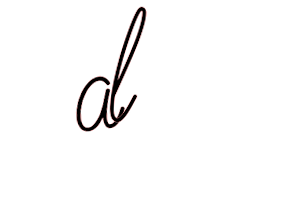

In [355]:
im

In [235]:
class FontDataset(gluon.data.Dataset):
    def __init__(self, fonts=[
##                        'dataset/fonts/AdineKirnberg-Alternate.ttf',
#                        'dataset/fonts/AguafinaScript-Regular.ttf',
##                        'dataset/fonts/daisy.ttf',
                        'dataset/fonts/Linoleo Script.ttf',
##                       'dataset/fonts/mayqueen.ttf',
#                        'dataset/fonts/Otto.ttf',
#                        'dataset/fonts/Popsies.ttf',
##                        'dataset/fonts/SANTO___.TTF',
##                        'dataset/fonts/Scribble.ttf',
#                        'dataset/fonts/Suwa.ttf'
    ], 
                  ngrams=3, size=(128,128)):
        self.fonts = fonts
        self.ngrams = ngrams
        self.alphabet = list(' ' + string.ascii_letters + string.digits + string.punctuation)
        self.elements = self.alphabet
        self.size = size
        for i in range(self.ngrams-1):
            elements_ = []
            for word in self.elements:
                for letter in self.alphabet:
                    elements_.append(word+letter)
            self.elements = elements_
        a = 1
        
    def _get_img(self, text, font=None):
        W, H = self.size
        if font is None:
            font = ImageFont.truetype(self.fonts[random.randint(0, len(self.fonts)-1)], size=120)
        else:
            font = ImageFont.truetype(font, size=60)
        im = Image.new("RGB", (W,H), "white")
        draw = ImageDraw.Draw(im)
        im.rotate(5,  expand=1)
        w, h = draw.textsize(text, font)
        draw.text(((W-w)/2,(H-h)/2), text, fill="black", font=font)
        return im
            
    def __getitem__(self, idx):
        text = self.elements[idx]
        im = self._get_img(text)
        return nd.array(np.array(im).mean(axis=2)).expand_dims(axis=2), idx
        
    def __len__(self):
        return len(self.elements)    

In [156]:
train_dataset = FontDataset()

In [157]:
batch_size = 64

In [ ]:
train_data = gluon.data.DataLoader(train_dataset.transform_first(gluon.data.vision.transforms.ToTensor()), batch_size=batch_size, last_batch='rollover', shuffle=True, num_workers=8)

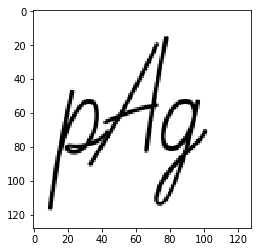

In [162]:
plt.imshow(train_dataset._get_img('pAg'))

## Convolutional autoencoder

In [163]:
net = gluon.nn.HybridSequential(prefix='autoencoder_')
with net.name_scope():
    # Encoder 1x28x28 -> 32x1x1
    encoder = gluon.nn.HybridSequential(prefix='encoder_')
    with encoder.name_scope():
        encoder.add(
            gluon.nn.Conv2D(channels=4, kernel_size=3, padding=2, activation='relu'),
            gluon.nn.BatchNorm(),
            gluon.nn.MaxPool2D(),
            gluon.nn.Conv2D(channels=8, kernel_size=3, padding=2, activation='relu'),
            gluon.nn.BatchNorm(),
            gluon.nn.MaxPool2D(),
            gluon.nn.Conv2D(channels=16, kernel_size=3, padding=2, activation='relu'),
            gluon.nn.BatchNorm(),
            gluon.nn.MaxPool2D(),
            gluon.nn.Conv2D(channels=32, kernel_size=3, padding=2, activation='relu'),
            gluon.nn.BatchNorm(),
            gluon.nn.MaxPool2D(),
            gluon.nn.Conv2D(channels=32, kernel_size=3, padding=2, activation='relu'),
            gluon.nn.MaxPool2D(),
            gluon.nn.Conv2D(channels=64, kernel_size=3, padding=2, activation='relu'),
            gluon.nn.MaxPool2D(),
            gluon.nn.Conv2D(channels=64, kernel_size=3, padding=0, activation='relu'),

        )
    decoder = gluon.nn.HybridSequential(prefix='decoder_')
    # Decoder 32x1x1 -> 1x28x28
    with decoder.name_scope():
        decoder.add(
            gluon.nn.Conv2D(channels=64, kernel_size=3, padding=2, activation='relu'),
            gluon.nn.HybridLambda(lambda F, x: F.UpSampling(x, scale=2, sample_type='nearest')),
            gluon.nn.BatchNorm(),
            gluon.nn.Conv2D(channels=32, kernel_size=3, padding=2, activation='relu'),
            gluon.nn.HybridLambda(lambda F, x: F.UpSampling(x, scale=2, sample_type='nearest')),
            gluon.nn.BatchNorm(),
            gluon.nn.Conv2D(channels=16, kernel_size=3, padding=1, activation='relu'),
            gluon.nn.HybridLambda(lambda F, x: F.UpSampling(x, scale=2, sample_type='nearest')),
            gluon.nn.BatchNorm(),
            gluon.nn.Conv2D(channels=8, kernel_size=3, padding=1, activation='relu'),
            gluon.nn.HybridLambda(lambda F, x: F.UpSampling(x, scale=2, sample_type='nearest')),
            gluon.nn.Conv2D(channels=4, kernel_size=3, padding=1, activation='relu'),
            gluon.nn.HybridLambda(lambda F, x: F.UpSampling(x, scale=2, sample_type='nearest')),
            gluon.nn.Conv2D(channels=1, kernel_size=1, padding=0, activation='sigmoid')
        )
    net.add(
        encoder,
        decoder
    )

In [164]:
ctx = mx.gpu(1)

In [165]:
net.initialize(ctx=ctx)

In [166]:
net.load_parameters('model_checkpoint/distance.params', ctx=ctx)

In [167]:
l2_loss = gluon.loss.L2Loss()
l1_loss = gluon.loss.L1Loss()

In [173]:
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': 0.0005, 'wd':0.00001})
net.hybridize(static_shape=True, static_alloc=True)

In [174]:
net.save_parameters('model_checkpoint/distance.params')

In [ ]:
epochs = 10
for e in range(epochs):
    curr_loss = 0.
    for i, (data, _) in enumerate(train_data):
        data = data.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            # Compute the L2 and L1 losses between the original and the generated image
            l2 = l2_loss(output.flatten(), data.flatten())
            l1 = l1_loss(output.flatten(), data.flatten())
            l =  l2 + l1 
        l.backward()
        trainer.step(data.shape[0])
        
        curr_loss += l.mean()
        if i % 200 == 0:
            print("[{}] loss: {:.4f}".format(i, curr_loss.asscalar()/(i+1)))

    print("Epoch [{}], Loss {}".format(e, curr_loss.asscalar()/(i+1)))

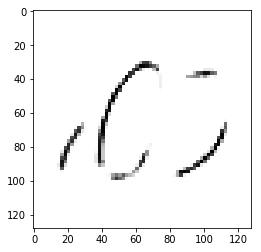

In [186]:
plt.imshow(output[10][0,:,:].asnumpy(), cmap='gray')

In [33]:
tf = gluon.data.vision.transforms.ToTensor()

In [69]:
img = nd.array(np.array(train_dataset._get_img("mn"))).mean(axis=2).expand_dims(axis=2)

In [ ]:
output = encoder(tf(img).as_in_context(ctx).expand_dims(axis=0)).squeeze().asnumpy()

In [187]:
batch_size = 1024
train_dataset = FontDataset()
train_data = gluon.data.DataLoader(train_dataset.transform_first(gluon.data.vision.transforms.ToTensor()), batch_size=batch_size, last_batch='rollover', shuffle=False, num_workers=8)

In [188]:
import hnswlib
import numpy as np

dim = 64
num_elements = len(train_dataset)

# Generating sample data
data = np.float32(np.random.random((num_elements, dim)))
data_labels = np.arange(num_elements)

# Declaring index
p = hnswlib.Index(space = 'l2', dim = dim) # possible options are l2, cosine or ip

# Initing index - the maximum number of elements should be known beforehand
p.init_index(max_elements = num_elements, ef_construction = 200, M = 16)

In [189]:
embeddings = np.zeros((len(train_dataset), 64))

In [190]:
%%time
for i, (data, _) in enumerate(train_data):
    data = data.as_in_context(ctx)
    output = net[0](data)
    embeddings[i*batch_size:(i+1)*batch_size, :] = output.squeeze().asnumpy()
    if i % 100 == 0 :
        print(i)

0
100
200
300
400
500
600
700
800
CPU times: user 15 s, sys: 12.7 s, total: 27.7 s
Wall time: 2min 35s


In [191]:
# Element insertion (can be called several times):
p.add_items(embeddings, data_labels)

# Controlling the recall by setting ef:
p.set_ef(50) # ef should always be > k

In [193]:
train_dataset = FontDataset()

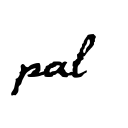

In [194]:
img_

In [ ]:
# Query dataset, k - number of closest elements (returns 2 numpy arrays)
img_ = train_dataset._get_img("lal")
img = nd.array(np.array(img_)).mean(axis=2).expand_dims(axis=2)
output = net[0](tf(img).as_in_context(ctx).expand_dims(axis=0)).squeeze().asnumpy()
labels, distances = p.knn_query(output, k = 100)
[train_dataset.elements[i] for i in labels[0]]